Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

In [2]:
# Load dataset
raw_data = pd.read_excel('./import/DataSet_V47.xlsx')

columns_in_data = ['Age', 
           'ОССН KiLLip', 
           'ЧСС (b)', 
           'Систолическое АД(b)', 
           'Креатинин', 
           'EF%',
           'Лейкоциты(b)',
           'Глюкоза(a)',
           'начало операции',
           'Дата операции в БД',
           'дата выписки',
           'дата смерти',
           'Исход заболевания']

data=raw_data.loc[(raw_data['STEMI']== 'Да')  & 
                   (raw_data['Наличие в БД']== 'Да')  & 
                  (raw_data['Наличие в файле']== 'Да') &
                   (raw_data['ЧКВ']== 'Да'),
                   columns_in_data]

columns_to_check = ['Age',
                   'ЧСС (b)', 
                   'Систолическое АД(b)', 
                   'Креатинин',
                   'EF%', 
                   'Лейкоциты(b)',  
                   'Глюкоза(a)']

data_no_nan = data.dropna(subset=columns_to_check)

data_no_nan_copy = data_no_nan.copy()
for col_name in ['Дата операции в БД', 'дата выписки', 'дата смерти']:
    new_col_name = f"{col_name}_parsed"
    data_no_nan_copy[new_col_name] = pd.to_datetime(data_no_nan_copy[col_name], errors='coerce')

query_expression = "(not `дата смерти`.isnull() and `Исход заболевания` != 'умер')"

# Applying De Morgan's laws to the query
query_expression_2 = "(`дата смерти`.isnull() or `Исход заболевания` == 'умер')"

# Drop rows that satisfy the query expression
clean_data = data_no_nan_copy.query(query_expression_2)

mask = (
    (clean_data['дата смерти_parsed'].notna()) & 
                (clean_data['дата смерти_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
    | ((clean_data['дата смерти_parsed'].isna()) & 
                (clean_data['Исход заболевания'] == 'умер') & 
                (clean_data['дата выписки_parsed'].notna()) & 
                (clean_data['дата выписки_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
        )
)

rows_to_keep = ~mask
ready_data = clean_data[rows_to_keep]
ready_data.describe()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000


# 2. Split the dataset into features and target.

In [3]:
X = ready_data[['Age', 
                        'ОССН KiLLip', 
                        'ЧСС (b)', 
                        'Систолическое АД(b)', 
                        'Креатинин', 
                        'EF%', 
                        'Лейкоциты(b)', 
                        'Глюкоза(a)']]
y = ready_data['Исход заболевания'].apply(lambda x: 1 if x == 'умер' else 0)

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [4]:
random_states = [0, 25, 42]

## 3. Keras

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
import shap

shap_values_list = []

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [38]:
def create_model(neurons=6):
    model = Sequential([
        layers.Dense(8, activation='relu', input_shape=[8]),
        layers.Dense(neurons, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[AUC(name='auc'), Precision(), Recall()]
    )
    return model

In [53]:
tf.random.set_seed(42)

model = KerasClassifier(model=create_model, verbose=3)

neurons_number = [6, 8, 10]
batch_size = [10, 20, 40]
learn_rate = [0.001, 0.01, 0.1]
momentum = [0.5, 0.75, 0.9]
early_stopping_monitor = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)

param_grid = dict(batch_size=batch_size, 
                    model__neurons=neurons_number,
                    optimizer__learning_rate=learn_rate, 
                    optimizer__momentum=momentum,
                    optimizer__callbacks = [[early_stopping_monitor]])
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=3, refit=True)

grid_result = grid.fit(X, y)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [54]:
# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: 0.9659394669147829 using {'batch_size': 10, 'model__neurons': 6, 'optimizer__callbacks': [<keras.callbacks.EarlyStopping object at 0x000001EC58428BB0>], 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.75}


In [62]:
final_model = create_model()

In [32]:
best_model = grid.best_estimator_.model



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
loss, auc, accuracy, precision, recall = best_model.evaluate(X_test, y_test)    

print(f"{loss=}, {auc=}, {accuracy=}, {precision=}, {recall=}")
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

AttributeError: 'function' object has no attribute 'evaluate'

In [64]:
for random_state in random_states:
    tf.random.set_seed(random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    final_model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50)

    explainer = shap.DeepExplainer(final_model, X_train)
    shap_values = explainer.shap_values(X_test)
    
    
    shap_values_list.append(shap_values[0])

Epoch 1/50
76/76 [==============================] - 3s 23ms/step - loss: 0.6121 - auc: 0.2781 - accuracy: 0.7524 - precision_7: 0.0187 - recall_7: 0.1176 - val_loss: 0.4923 - val_auc: 0.3257 - val_accuracy: 0.9488 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/50
76/76 [==============================] - 0s 6ms/step - loss: 0.4213 - auc: 0.2473 - accuracy: 0.9611 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 0.3382 - val_auc: 0.3952 - val_accuracy: 0.9686 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/50
76/76 [==============================] - 0s 6ms/step - loss: 0.3010 - auc: 0.3183 - accuracy: 0.9649 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 0.2354 - val_auc: 0.5414 - val_accuracy: 0.9686 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 4/50
76/76 [==============================] - 0s 5ms/step - loss: 0.2243 - auc: 0.4465 - accuracy: 0.9649 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Epoch 1/50
76/76 [==============================] - 1s 9ms/step - loss: 0.1009 - auc: 0.9182 - accuracy: 0.9657 - precision_7: 0.5769 - recall_7: 0.1724 - val_loss: 0.0848 - val_auc: 0.8914 - val_accuracy: 0.9785 - val_precision_7: 0.8333 - val_recall_7: 0.2941
Epoch 2/50
76/76 [==============================] - 0s 5ms/step - loss: 0.1009 - auc: 0.9188 - accuracy: 0.9669 - precision_7: 0.6667 - recall_7: 0.1609 - val_loss: 0.0854 - val_auc: 0.8903 - val_accuracy: 0.9818 - val_precision_7: 0.8750 - val_recall_7: 0.4118
Epoch 3/50
76/76 [==============================] - 0s 5ms/step - loss: 0.1003 - auc: 0.9191 - accuracy: 0.9661 - precision_7: 0.5926 - recall_7: 0.1839 - val_loss: 0.0856 - val_auc: 0.8910 - val_accuracy: 0.9785 - val_precision_7: 0.8333 - val_recall_7: 0.2941
Epoch 4/50
76/76 [==============================] - 0s 4ms/step - loss: 0.1001 - auc: 0.9195 - accuracy: 0.9661 - precision_7: 0.6087 - recall_7: 0.1609 - val_loss: 0.0855 - val_auc: 0.8905 - val_accuracy: 0.9785 -

In [76]:
y.value_counts()


0    2920
1     104
Name: Исход заболевания, dtype: int64

In [65]:
shap_values[0]

array([[ 0.00516099, -0.01527252, -0.01387175, ...,  0.00677748,
        -0.00473594,  0.00351055],
       [-0.00611294, -0.01570246,  0.01017768, ...,  0.01246612,
        -0.00664576, -0.00210585],
       [-0.00151833, -0.00846379, -0.01194576, ...,  0.00566273,
        -0.00784269, -0.00376657],
       ...,
       [-0.00207439, -0.00561188, -0.00362756, ..., -0.00917915,
        -0.00932646, -0.00021058],
       [-0.00135225,  0.00213676, -0.00829006, ..., -0.01039812,
        -0.00966243, -0.00359726],
       [ 0.00683875, -0.01575616,  0.0149869 , ..., -0.0139744 ,
        -0.0041883 ,  0.00212524]])

In [77]:
mean_shap_values = np.mean(shap_values_list, axis=0)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


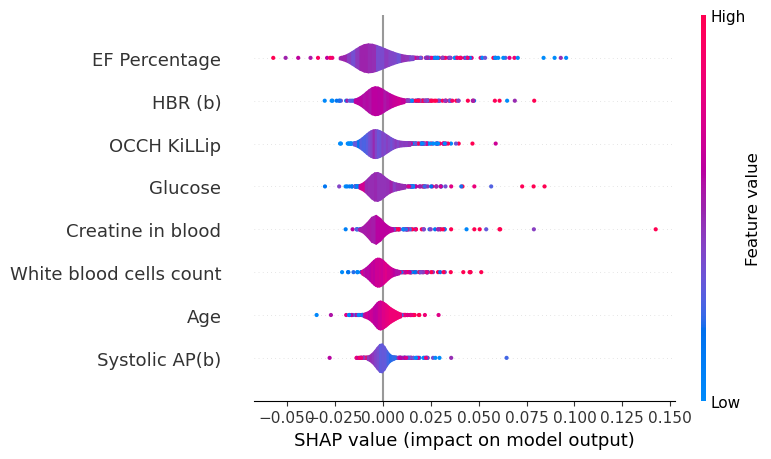

In [78]:
feature_names = ["Age", "ОССН KiLLip", "HBR (b)", "Systolic AP(b)", "Creatine in blood", "EF Percentage", "White blood cells count", "Glucose"]
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names, plot_type='violin')

In [79]:
feature_importances = pd.DataFrame(index=feature_names)

total_mean_shap_values = np.mean(np.abs(mean_shap_values), axis=0)
feature_importances['mean_shap'] = total_mean_shap_values

display(feature_importances)

,mean_shap
Age,0.004364
ОССН KiLLip,0.007352
HBR (b),0.007884
Systolic AP(b),0.003821
Creatine in blood,0.005956
EF Percentage,0.011707
White blood cells count,0.005452
Glucose,0.006289


In [80]:
import matplotlib.pyplot as plt

def plot_weights_single(feature_importances, column1, label1, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))

    plt.figure(figsize=(10, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='yellow', height=barWidth, edgecolor='grey', label=label1)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  

    add_values(bars1)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()


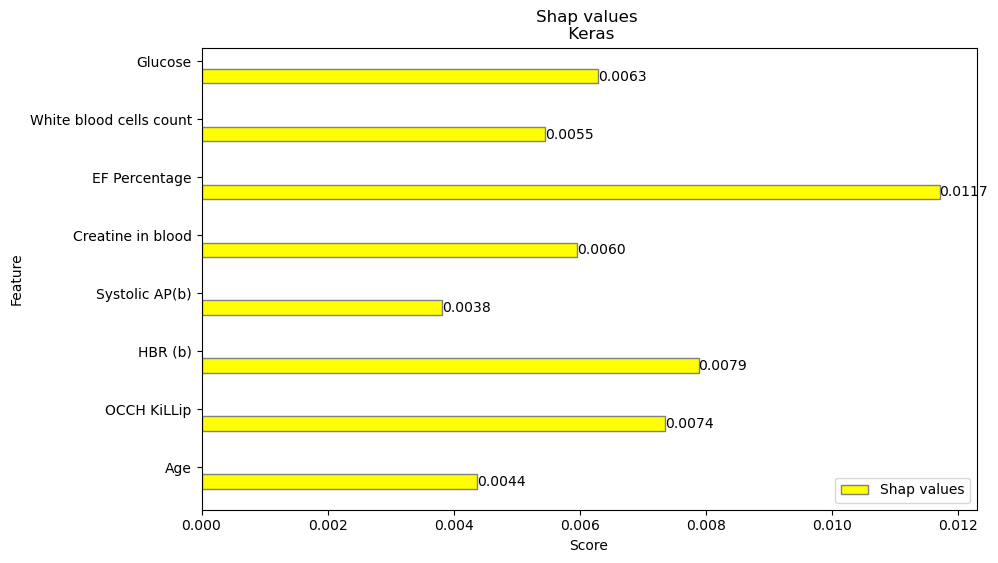

In [81]:
plot_weights_single(feature_importances, 
             column1='mean_shap', 
             label1='Shap values', 
             title='Shap values \n Keras',
             num_digits=4)